<a href="https://colab.research.google.com/github/maksikutrolli/DQN-DCC/blob/main/DQN_discrete_classic_controls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Simple DQN to solve discrete classic controls

https://www.gymlibrary.dev/environments/classic_control/

Install gym library

In [70]:
%pip install -U gym 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import Libraries needed for this implemntation

In [ ]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

We divided the implementation into the following five major sections:

  1- Define the ReplayBuffer data structure to store and manage the experience (memory) of the agent.

  2- Define a model that agent will use to determine its actions, known as the policy of the agent. 

  3- Define a data structure for Agent. 

  4- Create and train the agent for {"Acrobot-v1" , "CartPole-v1" , "MountainCar-v0"}.

  5- Test the agent for 100 episode.


In [71]:
#

In [ ]:
#

1- Define the ReplayBuffer data structure to store and manage the experience (memory) of the agent.

Data stored in this data structure will be used to train the agent (NN model). The reason we need to store the experience somewhere is that we want a model that generalizes well. To create such a model, we must add diversity to the training dataset by shuffling it randomly, and then use batch data to train the NN model. So the first step is to create a training dataset, which is the experience stored in this data structure.


In [72]:
class ReplayBuffer:
      def __init__(self, max_size ,input_shape, n_actions, replace = False):
          self.mem_size = max_size
          self.current_size = 0
          self.state_memory = np.zeros((self.mem_size, *input_shape))
          self.next_state_memory = np.zeros((self.mem_size, *input_shape))
          self.action_memory = np.zeros((self.mem_size))
          self.reward_memory =np.zeros(self.mem_size)
          self.done_memory = np.zeros(self.mem_size, dtype=bool)

          self.replace = replace # replace false prevents for double sampling memories in np.random.choice function

      def insert(self, state, action, reward, next_state, done):
          index = self.current_size % self.mem_size

          self.state_memory[index] = state
          self.action_memory[index] = action
          self.reward_memory[index] = reward
          self.next_state_memory[index] = next_state
          self.done_memory[index] = done
          self.current_size += 1
      
      def sample_buffer(self, batch_size):
          max_memory = min(self.current_size, self.mem_size) # maximum memory available 

          batch_indices= np.random.choice(max_memory, batch_size, replace=self.replace )
          
          states = self.state_memory[batch_indices]
          actions = self.action_memory[batch_indices]
          rewards = self.reward_memory[batch_indices]
          next_states = self.next_state_memory[batch_indices]
          dones = self.done_memory[batch_indices]

          return states, actions, rewards, next_states, dones

2- Define a model that the agent will use to determine its actions, known as the policy of the agent.

The qnet function creates a NN model with two hidden layers. The model takes as input an observation (current state) and predicts the Q-Values for each action. Therefore, the input shape of the NN is equal to the observation shape, and the output shape of the NN is equal to the number of actions an agent can take. Both input and output shapes are defined by the environment. The best action an agent can take using this model is the action with the largest predicted Q-Value.

In [73]:
def qnet(input_dims =1, output_dims=2, fcl1_dims=32, fcl2_dims=32, model_name='QNetwork'):

    model_input = keras.layers.Input(shape=(input_dims))
    out = keras.layers.Dense(fcl1_dims, activation="elu")(model_input)
    out = keras.layers.Dense(fcl2_dims, activation="elu")(out)
    model_output = keras.layers.Dense(output_dims)(out)

    model = tf.keras.Model(model_input, model_output)
    return model

3- Define a data structure for Agent.

*   Init method

  In this method, we will initialize the member's agent needs to learn the environment, which includes:

  1.   Create a replay_memory member from the RplayBuffer data structure.  
  
  2.   Create a model member using the qnet function.

  3.   Initialize a reward function in case needed. 



*   Define an Epsilon greedy policy method

  The epsilon greedy policy is a method used to balance the exploration and exploitation, this way we make sure that the agent explores the environment. This is done by choosing a random action with a probability epsilon (if random < epsilon: explore else: exploit). 

*   Define a remember method 
  
  This method will be used to save the experience [state, action, reward, next_state, dome] in the replay_buffer memory.


*   Define a train method 
  
  This method will be used to train the agent model.
  

*   Define a save_model method 
  
  This method will be used to save the best weights of the model.

*   Define a load_model method 
  
  This method will be used to load weights from a saved model.

In [74]:
class Agent:
      def __init__(self, game_name, buffer_dims, buffer_max_size = 20_000, gamma = 0.95, env = None, fcl1_dims = 64, fcl2_dims = 64, batch_size = 32, n_actions = 2, obs_shape = 2, reward_function = None):
        
        self.game_name = game_name
        self.replay_memory = ReplayBuffer(max_size = buffer_max_size, input_shape = buffer_dims, n_actions = n_actions)
        self.gamma = gamma
        self.batch_size = batch_size
        self.n_actions = n_actions
        self.fcl1_dims = fcl1_dims
        self.fcl2_dims = fcl2_dims

        self.reward_function = reward_function

        self.model  = qnet(fcl1_dims = self.fcl1_dims, fcl2_dims = self.fcl2_dims, output_dims = self.n_actions, input_dims = obs_shape)

        self.optimizer = keras.optimizers.Adam(learning_rate=1e-2)
        self.loss_fn = keras.losses.MeanSquaredError()

        self.checkpoint_file = self.game_name + '_dqn.h5'

      def remember(self, state, action, reward, next_state, dome):
        self.replay_memory.insert(state, action, reward, next_state, dome)

      def epsilon_greedy_policy(self, state, epsilon=0):
          if np.random.rand() < epsilon:
              return np.random.randint(self.n_actions)
          else:
              Q_values = self.model.predict(state[np.newaxis])
              return np.argmax(Q_values[0])  
      
      def train(self):
          states, actions, rewards, next_states, dones = self.replay_memory.sample_buffer(self.batch_size)

          next_Q_Values = self.model.predict(next_states)
          next_Q_Values = np.max(next_Q_Values, axis=1)
          target_Q_Values = rewards + (1 - dones) * self.gamma * next_Q_Values
          target_Q_Values = target_Q_Values.reshape(-1, 1)
          action_mask = tf.one_hot(actions, self.n_actions)

          with tf.GradientTape() as tape:
              Q_Values = self.model(states)
              Q_Values = tf.reduce_sum(Q_Values * action_mask, axis=1, keepdims=True)
              loss = tf.reduce_mean(self.loss_fn(target_Q_Values, Q_Values))
          grads = tape.gradient(loss, self.model.trainable_variables)
          self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

      def save_model(self):
        print('....saving model....')
        self.model.save_weights(self.checkpoint_file)

      def load_model(self):
        print('....loading model....')
        self.model.load_weights(self.checkpoint_file)


In addition, we created some other functions that will help us to speed up learning and manage the best achievement of an agent. These functions are custom and specific for each environment.

In [75]:
def mountain_car_reward_function(state, max_step, step):
    if state[0] >= 0.5:
        return (max_step-step) *(1+0.5)**2
    if state[0] > -0.4:
        return (1+state[0])**2
    if state[0] < -0.7:
        return (1+state[0])**2
    return 0

In [76]:
def acrobot_reward_function(state, max_step, step):
    v = -state[0] - ((state[0] * state[2]) - (state[1] * state[3]))
    if v > 1:
        return (max_step-step) *(1 + 1)**2
    if v > -1.5:
        return (1+v)**2
    return 0

In [77]:

def mountain_car_best_achievement(step, best_steps):
  return step <= best_steps

In [78]:
def acrobot_best_achievement(step, best_steps):
  return step <= best_steps

In [79]:
def cartpole_best_achievement(step, best_steps):
  return step >= best_steps

Setup train properties based on the game.

In [80]:
def get_game_properties(game_name):
  reward_function = None
  max_episodes = 0
  max_steps = 0
  best_score = 0
  best_score = 0
  if(game_name == "CartPole-v1"):
    reward_function = None
    best_achievement = cartpole_best_achievement
    max_episodes = 600
    episode_min_epsilon =500
    min_epsilon = 0.01
    max_steps = 200
    best_score = 0
    best_steps = 0
  if(game_name == "MountainCar-v0"):
    reward_function = mountain_car_reward_function
    best_achievement = mountain_car_best_achievement
    max_episodes = 700
    episode_min_epsilon =600
    min_epsilon = 0.05
    max_steps = 200
    best_score = 0
    best_steps = max_steps
  if(game_name == "Acrobot-v1"):
    reward_function = acrobot_reward_function
    best_achievement = acrobot_best_achievement
    max_episodes = 600
    episode_min_epsilon =500
    min_epsilon = 0.01
    max_steps = 500
    best_score = 0
    best_steps = max_steps

  return reward_function, best_achievement, max_episodes, episode_min_epsilon, min_epsilon, max_steps, best_score, best_steps


In [81]:
def get_model_properties(game_name):

  if(game_name == "CartPole-v1"):
    fcl1_dims, fcl2_dims , batch_size = 32, 32, 32 
  if(game_name == "MountainCar-v0"):
    fcl1_dims, fcl2_dims , batch_size = 64, 64, 32
  if(game_name == "Acrobot-v1"):
    fcl1_dims, fcl2_dims , batch_size = 32, 32, 32

  return fcl1_dims, fcl2_dims , batch_size


In [82]:
env_seed = 42

# env.seed(env_seed)
np.random.seed(env_seed)
tf.random.set_seed(env_seed)

tf.keras.utils.disable_interactive_logging()

4- Create and train the agent

Choose one game from the list {"Acrobot-v1" ,  "CartPole-v1" , "MountainCar-v0"} 


In [83]:
#
game_name = "Acrobot-v1"

#
reward_function, best_achievement, max_episodes, episode_min_epsilon, min_epsilon, max_steps, best_score, best_steps = get_game_properties(game_name)

#
env = gym.make(game_name)

#
buffer_max_size = 20_000
buffer_dims = env.observation_space.shape

#
obs_shape, action_shape = env.observation_space.shape[0], env.action_space.n

#
fcl1_dims, fcl2_dims , batch_size = get_model_properties(game_name)

#discount factor
gamma = 0.95

In [84]:
#Create an agent
agent = Agent(game_name = game_name, buffer_dims = buffer_dims, buffer_max_size = buffer_max_size, gamma = gamma, env = env, fcl1_dims = fcl1_dims, fcl2_dims = fcl2_dims, batch_size = batch_size, n_actions = action_shape, obs_shape = obs_shape, reward_function = reward_function)


In [85]:

scores = []
steps = []

for episode in range(max_episodes):
    state = env.reset()[0]
    score = 0
    done = False   
    for step in range(max_steps):
        epsilon = max(1 - episode / episode_min_epsilon, min_epsilon)

        action = agent.epsilon_greedy_policy(state, epsilon)

        next_state, reward, done, info,_ = env.step(action)

        if agent.reward_function != None:
            reward = agent.reward_function(next_state, max_steps, step)

        agent.remember(state, action, reward, next_state, done)
        state = next_state
        # env.render()

        score += reward
        if done:
            print("Peekaboo, I see you! :)")
            break
    scores.append(score)
    steps.append(step+1)
    if best_achievement(step + 1, best_steps):
        if done:  agent.save_model()
        best_steps = step + 1
        if (score > best_score): best_score = score
    print("\rEpisode: {}, Steps: {}, Best Steps: {}, Score: {:.1f}, Best_Score: {:.1f}, epsilon: {:.3f}".format(episode, step + 1, best_steps, score, best_score, epsilon))
    if episode > 1:
        agent.train()


Episode: 0, Steps: 500, Best Steps: 500, Score: 9.2, Best_Score: 9.2, epsilon: 1.000
Episode: 1, Steps: 500, Best Steps: 500, Score: 15.1, Best_Score: 15.1, epsilon: 0.998
Episode: 2, Steps: 500, Best Steps: 500, Score: 16.1, Best_Score: 16.1, epsilon: 0.996
Episode: 3, Steps: 500, Best Steps: 500, Score: 52.1, Best_Score: 52.1, epsilon: 0.994
Episode: 4, Steps: 500, Best Steps: 500, Score: 96.3, Best_Score: 96.3, epsilon: 0.992
Episode: 5, Steps: 500, Best Steps: 500, Score: 86.7, Best_Score: 96.3, epsilon: 0.990
Episode: 6, Steps: 500, Best Steps: 500, Score: 60.5, Best_Score: 96.3, epsilon: 0.988
Episode: 7, Steps: 500, Best Steps: 500, Score: 6.0, Best_Score: 96.3, epsilon: 0.986
Episode: 8, Steps: 500, Best Steps: 500, Score: 9.4, Best_Score: 96.3, epsilon: 0.984
Episode: 9, Steps: 500, Best Steps: 500, Score: 49.9, Best_Score: 96.3, epsilon: 0.982
Episode: 10, Steps: 500, Best Steps: 500, Score: 48.1, Best_Score: 96.3, epsilon: 0.980
Episode: 11, Steps: 500, Best Steps: 500, Scor

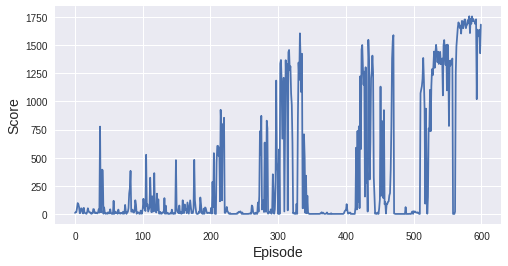

In [86]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.figure(figsize=(8, 4))
plt.plot(scores)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.savefig(game_name + '_scores' ,dpi=600)
plt.show()


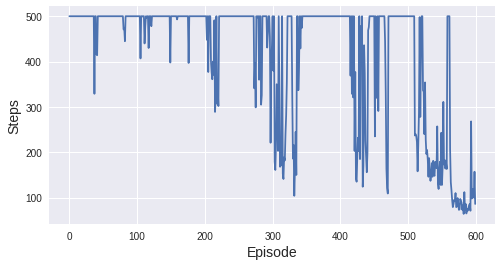

In [87]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.figure(figsize=(8, 4))
plt.plot(steps)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Steps", fontsize=14)
plt.savefig(game_name + '_steps'  ,dpi=600)
plt.show()

  5- Test the agent for 100 episode.

In [88]:
def play_ones_step(env, state):
    Q_Values = agent.model.predict(state[np.newaxis]) 
    action = np.argmax(Q_Values[0])
    next_state, reward, done, info,_  = env.step(action)
    return next_state, reward, done, info

In [89]:
#load the best weights
agent.load_model()

obs = env.reset()[0]  

obs, reward, done, info = play_ones_step(env, obs)
sum_steps = 0

steps = []

episodes = 100

for episode in range(episodes):
    obs = env.reset()[0]    
    for step in range(200):
        obs, reward, done, info = play_ones_step(env, obs)
        if done or step == max_steps -1:
            step += 1
            steps.append(step)
            sum_steps = sum_steps + step
            avg = sum_steps/(episode+1)
            print("\rEpisode: {}, Steps: {}, avg: {:.3f}".format(episode, step, avg))
            break


sum_steps

....loading model....
Episode: 0, Steps: 65, avg: 65.000
Episode: 1, Steps: 72, avg: 68.500
Episode: 2, Steps: 76, avg: 71.000
Episode: 3, Steps: 76, avg: 72.250
Episode: 4, Steps: 93, avg: 76.400
Episode: 5, Steps: 65, avg: 74.500
Episode: 6, Steps: 88, avg: 76.429
Episode: 7, Steps: 75, avg: 76.250
Episode: 8, Steps: 65, avg: 75.000
Episode: 10, Steps: 85, avg: 69.091
Episode: 11, Steps: 95, avg: 71.250
Episode: 12, Steps: 87, avg: 72.462
Episode: 13, Steps: 65, avg: 71.929
Episode: 14, Steps: 95, avg: 73.467
Episode: 15, Steps: 73, avg: 73.438
Episode: 16, Steps: 97, avg: 74.824
Episode: 17, Steps: 64, avg: 74.222
Episode: 18, Steps: 65, avg: 73.737
Episode: 19, Steps: 95, avg: 74.800
Episode: 20, Steps: 73, avg: 74.714
Episode: 21, Steps: 65, avg: 74.273
Episode: 22, Steps: 89, avg: 74.913
Episode: 23, Steps: 95, avg: 75.750
Episode: 24, Steps: 112, avg: 77.200
Episode: 25, Steps: 64, avg: 76.692
Episode: 26, Steps: 65, avg: 76.259
Episode: 27, Steps: 65, avg: 75.857
Episode: 28, S

7976

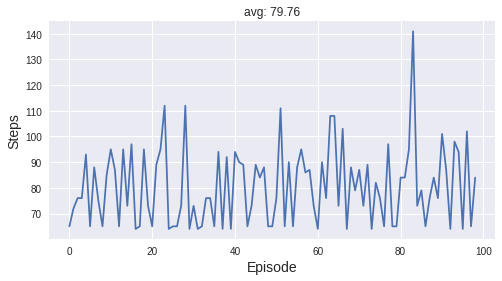

In [90]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.figure(figsize=(8, 4))
plt.plot(steps)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Steps", fontsize=14)
title = "avg: " + str(sum_steps/(episode+1))
plt.title(title)
plt.savefig(game_name + '_test_agent_100_episodes',dpi=600)
plt.show()